In [1]:
#--------------------------------
## IMPORTS
#--------------------------------
import sys
import os

# set the path to find the modules
sys.path.insert(0, '../005_src/') #use relative path
#os.chdir("../005_src")

from config import *

----------------------------------------
Packages import successful
Variables import successful
Helper Functions import successful
Functions import successful
Functions xml import successful
Functions graph import successful
Functions GCN import successful
Functions Plotting import successful
----------------------------------------
root directory: /storage/remote/atcremers50/ss21_multiagentcontrol/
input directory: /storage/remote/atcremers50/ss21_multiagentcontrol/004_data/
output directory: /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/
----------------------------------------



In [2]:
device = cudaOverview()

CUDA not available, running on cpu


In [3]:
from _03_Networks.GCN_006.GCN_model_006 import *
check_import()
from _03_Networks.GCN_006.GCN_trainer_006 import *
this_GCN, ts = check_import()
this_date = get_date()

imported model: GCN_006 at 11h26m51s
edges_attr=True
imported trainer: GCN_006 at 11h26m51s


In [4]:
##================================
## INIT SAVING PATHS
##================================

MODEL_OUTPUT_PATH = os.path.join(OUTPUT_DIR,f"{this_GCN}/")
MODEL_OUTPUT_PATH_TODAY = os.path.join(MODEL_OUTPUT_PATH,f"{this_date}{ts}/")
print (MODEL_OUTPUT_PATH_TODAY)
if not os.path.exists(MODEL_OUTPUT_PATH_TODAY):
    Path(MODEL_OUTPUT_PATH_TODAY).mkdir(parents=True, exist_ok=True)
    
dict_text_output = {}

/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/


In [5]:
##================================
## MODEL VAR
##================================

random_seed = 42
train_size = 0.9  
batch_size = 256 # maybe 100 is too much...

Nepochs =10
savestat = True
intentionstat = True
save_every = int(Nepochs/2) # temp pkl, pt, png, can delete after final is stored
transformstat = False
plotstat = True
printstat = True

training_losses = []
validation_losses = []
lr_rates = []

# create keys and values for all the stuff that you want later on print out in txt files
dict_text_output.update({
                    'run_time':ts,
                    'model': this_GCN,
                    'random_seed': random_seed,
                    'train_size':train_size,
                    'batch_size': batch_size,
                    'Nepochs': Nepochs,
                    'save_every':save_every, 
                    'transformstat': transformstat,
                    'plotstat': plotstat,
                    'printstat' : printstat,
                    'intentionstat':intentionstat
    
                    })


In [6]:
##================================
## LOAD DATA
##================================
input_file_name = "20210710-13h21m45s_timesteps15000_ec3500_em7000"
dict_text_output["input_file_name"] = input_file_name

txt_data = os.path.join(GCN_INPUT_FOLDER,f"{input_file_name}.txt")
dict_text_data = read_txt_data(txt_data)

dict_text_output['input_file_name'] = input_file_name

In [7]:
##if plotstat:
#path_figure = read_txt_data(dict_text_data['info_input_df'])["path_figure"]
#Image(open(f'{path_figure}','rb').read())

In [8]:
##if plotstat:
#path_GIF = dict_text_data["path_GIF"]
#Image(open(f'{path_GIF}','rb').read())

The function "" select only the rows marked with "training row" True.


In [9]:
print (f"\n> SELECTING INPUT ROWS")

df_all,df_selected = select_rows_from_data(input_file_name,drop_col = True)
printif(df_all.loc[15],printstat)


> SELECTING INPUT ROWS
data_x                [[180.0, 19.49, 1.0], [0.0, 16.23, 1.0], [90.0...
data_pos                [[98.4, 29.75], [101.6, 107.05], [31.88, 98.4]]
data_edges                                       [[0, 0, 1], [1, 2, 2]]
data_edges_renamed                               [[0, 0, 1], [1, 2, 2]]
data_y                      [[101.6, 140.07, 0.0], [55.94, 98.4, 90.0]]
data_edges_attr                                         [2.0, 1.9, 2.2]
training_row                                                      False
Name: 15, dtype: object


In [10]:
printif(f"selected {len(df_selected)} coherent rows over {len(df_all)} total",printstat)

selected 10105 coherent rows over 14995 total


In [11]:
df_input = df_selected

In [12]:
dict_text_data.keys()

dict_keys(['max_num_veh', 'date', 'time', 'usr', 'env', 'path_input_df', 'info_input_df', 'sim_duration_timesteps', 'edge_creation_radius', 'edge_maintenance_radius', 'edge_weights_option', 'predict_after_timesteps', 'savestat', 'delete_temporary_files', 'plotstat', 'path_GCN_input', 'path_GIF'])

In [13]:
# get the max number of vehicle per time step M
# input data_x [Mx3]
# input data_pos [Mx2]
# output y [Mx3]
M = int(dict_text_data['max_num_veh'])
sim_duration_timesteps = dict_text_data['sim_duration_timesteps']
printif(f"max_num_veh: {M}",printstat)
printif(f"sim_duration_timesteps: {sim_duration_timesteps}",printstat)
dict_text_output['max_num_veh'] = max_num_veh
dict_text_output['sim_duration_timesteps'] = sim_duration_timesteps

max_num_veh: 10
sim_duration_timesteps: 15000


In [14]:
##================================
## TRAIN AND VALIDATION 
##================================
print (f"\n> SPLIT TRAIN AND VALIDATION")
c = df_input.index.tolist()
train_frames, valid_frames = train_test_split(
                                c,
                                random_state=random_seed,
                                train_size=train_size,
                                shuffle=True)

valid_frames, test_frames = train_test_split(
                                valid_frames,
                                random_state=random_seed,
                                train_size=0.9,
                                shuffle=True)

dict_text_output['num_rows_training'] = len(train_frames)
dict_text_output['num_rows_validation'] = len(valid_frames)
dict_text_output['num_rows_test'] = len(test_frames)


> SPLIT TRAIN AND VALIDATION


In [15]:
##================================
## VARIATIONS
##================================
# TODO ADD AS INPUT
exclude_yaw = True
paddingstat = False
concatenatestat = True
add_parameter = 0

if intentionstat:
    add_parameter = 1

printif("",printstat)
if concatenatestat:
    size_input = 4 + add_parameter
    printif(f"Input: concatenation(data_x,data_pos) [bacth_size,{size_input}]",printstat)
else:
    size_input = 2 + add_parameter
    printif(f"Input: concatenation(data_x) [bacth_size,{size_input}]",printstat)
if exclude_yaw:
    size_output = 2
    printif(f"Predicting: X, Y [bacth_size,{size_output}]",printstat)
else:
    size_output = 3
    printif(f"Predicting: X, Y, Yaw [bacth_size,{size_output}]",printstat)
    
dict_text_output['exclude_yaw'] = exclude_yaw
dict_text_output['concatenatestat'] = concatenatestat
dict_text_output['paddingstat'] = paddingstat
dict_text_output['size_input'] = size_input
dict_text_output['size_output'] = size_output


Input: concatenation(data_x,data_pos) [bacth_size,5]
Predicting: X, Y [bacth_size,2]


In [16]:
##================================
## CREATING THE DATASET
##================================
print (f"> CREATING THE DATASET")

# here I have two Dataset creators, 
# Dataset_1 without intention, 
# Dataset_GCN with intention

if size_input% 2 == 0:
    printif("Training without intention",printstat)
    time.sleep(1)
    dataset_train = Dataset_1(
                         df_input,
                         train_frames,
                         #transform=transforms_training,
                         M = M,
                         printstat = False,
                         concatenatestat = concatenatestat,
                         paddingstat = paddingstat,
                         exclude_yaw = exclude_yaw
                         )
    dataset_val = Dataset_1(
                         df_input,
                         valid_frames,
                         M = M,
                         concatenatestat = concatenatestat,
                         paddingstat = paddingstat,
                         exclude_yaw = exclude_yaw
                         )
    dataset_test = Dataset_1(
                         df_input,
                         test_frames,
                         M = M,
                         concatenatestat = concatenatestat,
                         paddingstat = paddingstat,
                         exclude_yaw = exclude_yaw
                         )
    
else:
    printif("Training with intention",printstat)
    time.sleep(1)
    dataset_train = Dataset_GCN(
                         df_input,
                         train_frames,
                         #transform=transforms_training,
                         M = M,
                         printstat = False,
                         concatenatestat = concatenatestat,
                         paddingstat = paddingstat,
                         exclude_yaw = exclude_yaw
                         )
    dataset_val = Dataset_GCN(
                         df_input,
                         valid_frames,
                         M = M,
                         concatenatestat = concatenatestat,
                         paddingstat = paddingstat,
                         exclude_yaw = exclude_yaw
                         )
    dataset_test = Dataset_GCN(
                         df_input,
                         test_frames,
                         M = M,
                         concatenatestat = concatenatestat,
                         paddingstat = paddingstat,
                         exclude_yaw = exclude_yaw
                         )
printif(dataset_train,printstat, n = 10)

> CREATING THE DATASET
Training with intention


100%|██████████| 102/102 [00:00<00:00, 159.45it/s]

0) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
1) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
2) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
3) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
4) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
...
9089) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
9090) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
9091) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
9092) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
9093) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])


In [17]:
# STORE DATASET TEST
dataset_test_path = os.path.join(MODEL_OUTPUT_PATH_TODAY,f'dataset_test'+'.pkl')
with open(dataset_test_path, 'wb') as f:
    pkl.dump(dataset_test, f)

In [18]:
printif(f"\nexample of data from train: \n{dataset_train[0]}",printstat)


example of data from train: 
Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])


In [19]:
##================================
# DataLoader
##================================
print (f"\n> DATALOADER")
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


> DATALOADER


In [20]:
printif("")
printif(f"{len(train_loader.dataset)=}",printstat)
printif(f"{len(val_loader.dataset)=}",printstat)
printif(f"{len(test_loader.dataset)=}",printstat)


len(train_loader.dataset)=9094
len(val_loader.dataset)=909
len(test_loader.dataset)=102


In [21]:
##================================
## TRANSFORMATIONS
##================================
if transformstat: 
    # not implemented, not needed i think
    transforms_training = None
    transforms_validation = None
else:
    transforms_training = None
    transforms_validation = None

## GCN

In [22]:
##================================
## MODEL INIT
##================================

model = GCN(num_input_features=size_input,
            num_output_features =size_output,
            random_seed = random_seed,
            hc_1 = 16,
            #hc_2 = 32
           )

criterion = torch.nn.MSELoss()  # Define loss criterion for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=5e-4)  # Define optimizer.
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.6)# optimizer


In [23]:
printif(f"\n{model=}",printstat)
dict_text_output['model_architecture'] = model
dict_text_output['criterion']= criterion
dict_text_output['optimizer']= optimizer


model=GCN(
  (conv1): GCNConv(5, 16)
  (conv2): GCNConv(16, 2)
)


In [24]:
##================================
# Init Trainer Class
##================================

trainer = Trainer(
                 # Model parameters
                 model = model,
                 device = device,
                 criterion = criterion,
                 optimizer = optimizer,
                 
                 # Data 
                 training_DataLoader = train_loader,
                 validation_DataLoader = val_loader,
                 lr_scheduler = None,
                 
                 # trigger statements
                 printstat= True,
                 savestat = True,
                 
                 # store intermediate model as TEMP 
                 epochs = Nepochs,
                 epoch = 0, # starting epoch 
                 save_every = 5,
                 plot_every = 1, 
                 
                 # get intermediate results for each epoch
                 shuttle_train = None,
                 shuttle_val = None,
                 
                 # saving directory and description
                 save_dir = MODEL_OUTPUT_PATH_TODAY,
                 model_name = this_GCN,
                 date = this_date,
                 ts = ts,
                 notebook = True,
                 )

In [25]:
##================================
# Train
##================================
t_losses, v_losses, lr_r , load_paths, fig_paths = trainer.run_trainer()
print(f"> Training completed")

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Saved model in /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/20210711-11h26m51sEPOCH_5of10_TEMP__GCN_006.pt


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Saved model in /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/20210711-11h26m51sEPOCH_10of10_FINAL__GCN_006.pt
> Training completed


In [26]:
for k,v in load_paths.items():
    dict_text_output[k]= v
    
dict_text_output['final_train_loss']= t_losses[-1]
dict_text_output['final_val_loss']= v_losses[-1]

In [27]:
##================================
# DELETE TEMP FILES
##================================
print ("temporary files stored: ")
tempfiles = glob.glob(MODEL_OUTPUT_PATH_TODAY+'/*TEMP_*')
print (*tempfiles, sep= "\n")
print ("delete temporary files? y/n")
deletestat = input()
if deletestat in list_yes:
    for i, file_path in tqdm(enumerate(tempfiles)):
        try:
            os.remove(file_path)
        except OSError as e:
            print("Error: %s : %s" % (file_path, e.strerror))
    print ("temporary files deleted")
else:
    print ("temporary files not deleted")

temporary files stored: 
/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/20210711-11h26m51sEPOCH_5of10_TEMP__TEMP__learning_rate.pkl
/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/20210711-11h26m51sEPOCH_5of10_TEMP__TEMP__training_loss.pkl
/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/20210711-11h26m51sEPOCH_5of10_TEMP__GCN_006.pt
/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/20210711-11h26m51sEPOCH_5of10_TEMP__TEMP__validation_loss.pkl
delete temporary files? y/n
y


4it [00:00, 6538.28it/s]

temporary files deleted


In [29]:
##================================
# STORE RUN PARAMETERS
##================================
description = f"{this_date}{ts}"
dict_text_output_descr = f"{description}_training_parameters"
dict_text_output_path = os.path.join(MODEL_OUTPUT_PATH_TODAY,dict_text_output_descr)
print (f"\n> Parameters stored in: \n{dict_text_output_path}.pkl")
printif(f"> Dataset_test_path stored in: \n{dataset_test_path}",printstat)

# store parameters as txt file
TXT_OUTPUT = f'{dict_text_output_path}.txt'
with open(TXT_OUTPUT, 'w') as filehandle:
    for k,v in dict_text_output.items():
        filehandle.write(f'{k}: {v}\n')
    filehandle.close()
    
# store parameters as a pickle
with open(f'{dict_text_output_path}.pkl', 'wb') as handle:
    pkl.dump(dict_text_output, handle, protocol=pkl.HIGHEST_PROTOCOL)


> Parameters stored in: 
/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/20210711-11h26m51s_training_parameters.pkl
> Dataset_test_path stored in: 
/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/dataset_test.pkl


In [30]:
if printstat:
    np.set_printoptions(suppress=True)
    for data in dataset_val[:1]:
        print ("--------------")
        print ("\nINPUT DATA_POS,DATA_X")
        print (np.around(data.x.detach().numpy(),2))
        print ("\nTARGET DATA_Y")
        print (data.y.detach().numpy())
        print ("\nPREDICTIONS")
        print (model(data.x, data.edge_index,data.edge_attr).detach().detach().numpy())

--------------

INPUT DATA_POS,DATA_X
[[101.6   91.8    0.     0.     1.  ]
 [101.6   84.3    0.     0.     1.  ]
 [ 98.4  108.2  180.     0.     1.  ]
 [108.2  101.6  270.     0.     3.  ]
 [ 55.05 101.6  270.    11.9    0.  ]
 [ 91.64  98.4   90.     0.18   1.  ]
 [ 98.4  115.72 180.     0.12   1.  ]
 [ 78.94  98.4   90.     8.87   1.  ]
 [ 98.4  183.12 180.     6.29   1.  ]
 [190.21 101.6  270.     3.01   1.  ]]

TARGET DATA_Y
[[101.6   94.3 ]
 [101.6   84.3 ]
 [ 98.4  106.46]
 [108.2  101.6 ]
 [ 24.27 101.6 ]
 [ 91.8   98.4 ]
 [ 98.4  115.7 ]
 [ 84.08  98.4 ]
 [ 98.4  165.77]
 [180.17 101.6 ]]

PREDICTIONS
[[ 4.114372   2.0552077]
 [13.691749   6.389556 ]
 [13.60559    6.346895 ]
 [13.043193   6.0919366]
 [ 6.137613   2.9912276]
 [12.806569   6.0346236]
 [ 9.548987   4.5689464]
 [ 8.758161   4.227671 ]
 [ 4.901867   2.4629307]
 [ 5.075887   2.5478055]]


## RELOAD

In [31]:
reloaded_dict = pkl.load(open(f'{dict_text_output_path}.pkl',"rb"))
reloaded_dict

{'run_time': '11h26m51s',
 'model': 'GCN_006',
 'random_seed': 42,
 'train_size': 0.9,
 'batch_size': 256,
 'Nepochs': 10,
 'save_every': 5,
 'transformstat': False,
 'plotstat': True,
 'printstat': True,
 'intentionstat': True,
 'input_file_name': '20210710-13h21m45s_timesteps15000_ec3500_em7000',
 'num_rows_training': 9094,
 'num_rows_validation': 909,
 'num_rows_test': 102,
 'exclude_yaw': True,
 'concatenatestat': True,
 'paddingstat': False,
 'size_input': 5,
 'size_output': 2,
 'model_architecture': GCN(
   (conv1): GCNConv(5, 16)
   (conv2): GCNConv(16, 2)
 ),
 'criterion': MSELoss(),
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ),
 'model_path': '/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/20210711-11h26m51sEPOCH_10of10_FINAL__GCN_006.pt',
 'train_losses_path': '/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006

In [34]:
# load losses
t_losses_load = pkl.load(open( reloaded_dict['train_losses_path'], 'rb'))
v_losses_load = pkl.load(open( reloaded_dict['val_losses_path'], 'rb'))

Plot saved in /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_006/20210711-11h26m51s/20210711-11h26m51s_train_val_loss_plot.png


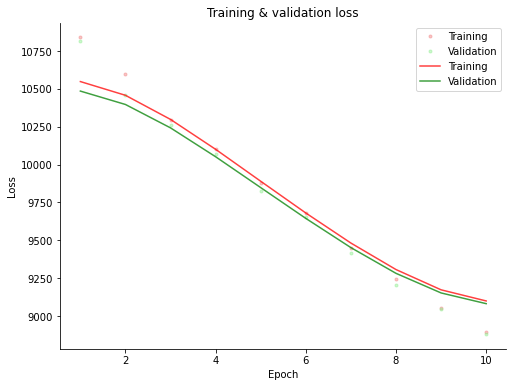

In [35]:
##================================
# TRAIN AND VAL LOSSES
##================================
fig = plot_training(t_losses_load,
                  v_losses_load,
                  learning_rate = None,
                  gaussian=True,
                  sigma=2,
                  figsize=(8, 6),
                  mytitle = 'Training & validation loss'
                  )

description = f"{this_date}{ts}"
new_png = f"{description}_train_val_loss_plot.png"
new_png_path = os.path.join(MODEL_OUTPUT_PATH_TODAY,new_png)
plt.savefig(new_png_path)
print (f"Plot saved in {new_png_path}")

## Verification
of results

In [37]:
# load model
# defining the model
load_model = GCN(num_input_features=size_input,
            num_output_features =size_output,
            random_seed = random_seed,
            hc_1 = 16,
           )

load_path = reloaded_dict['model_path']
load_model.load_state_dict(torch.load(load_path))
load_model.eval()



GCN(
  (conv1): GCNConv(5, 16)
  (conv2): GCNConv(16, 2)
)

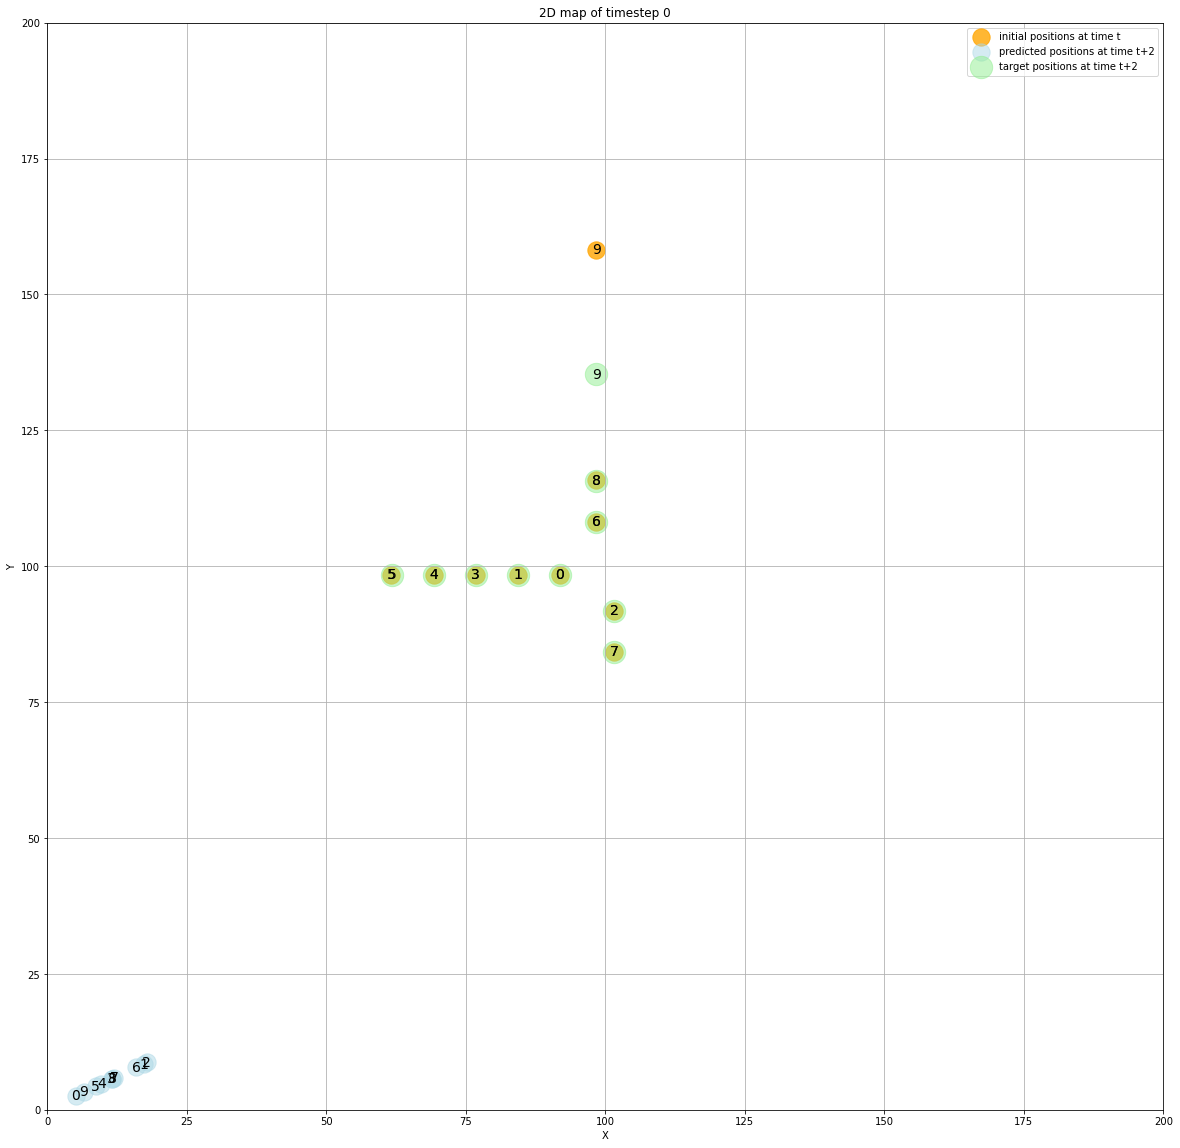

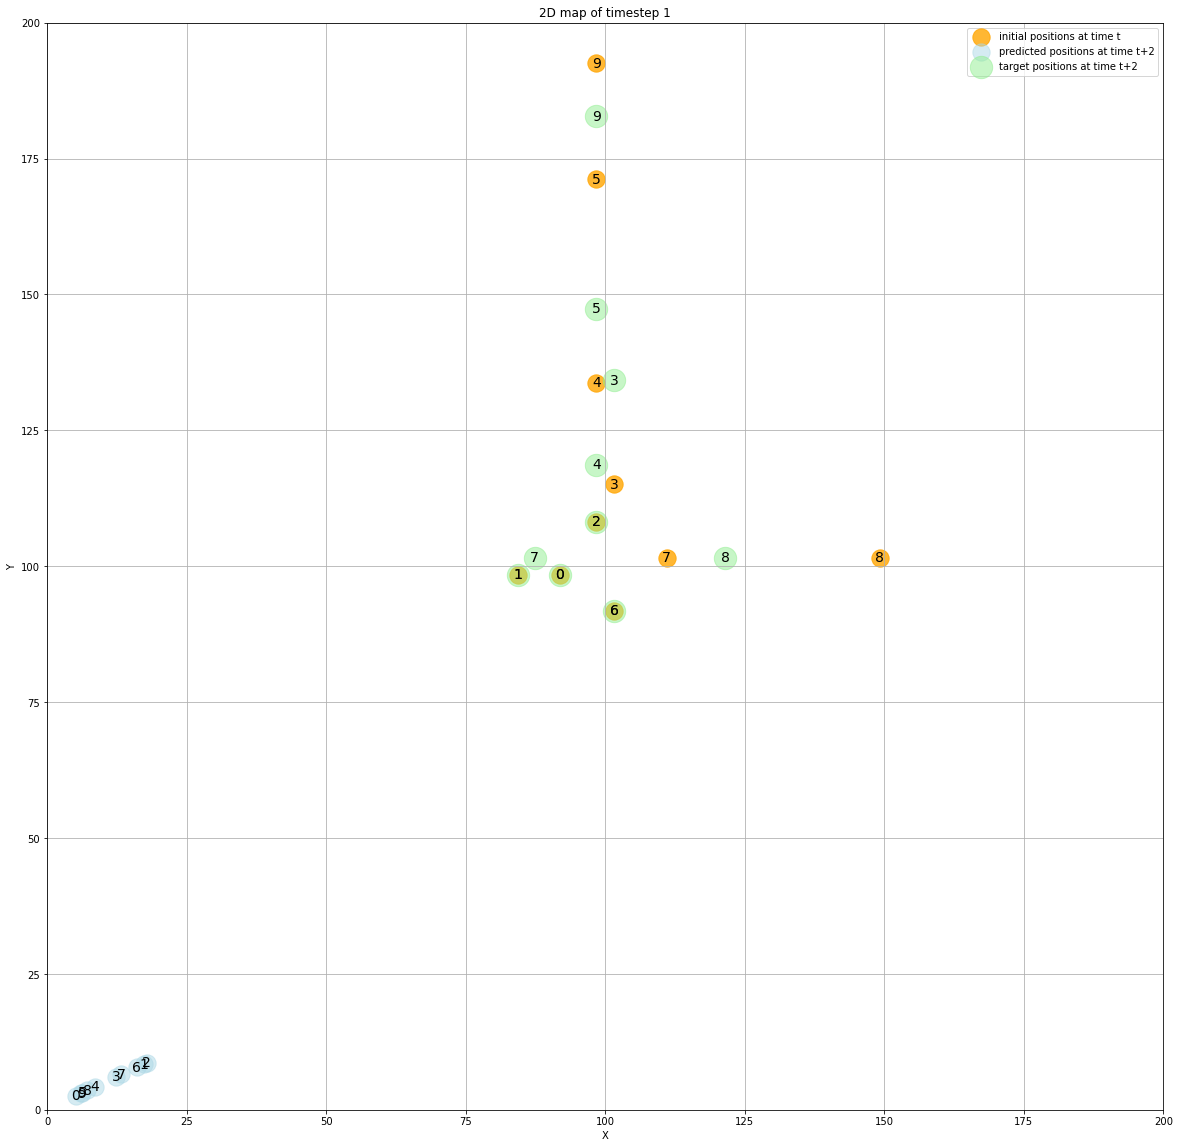

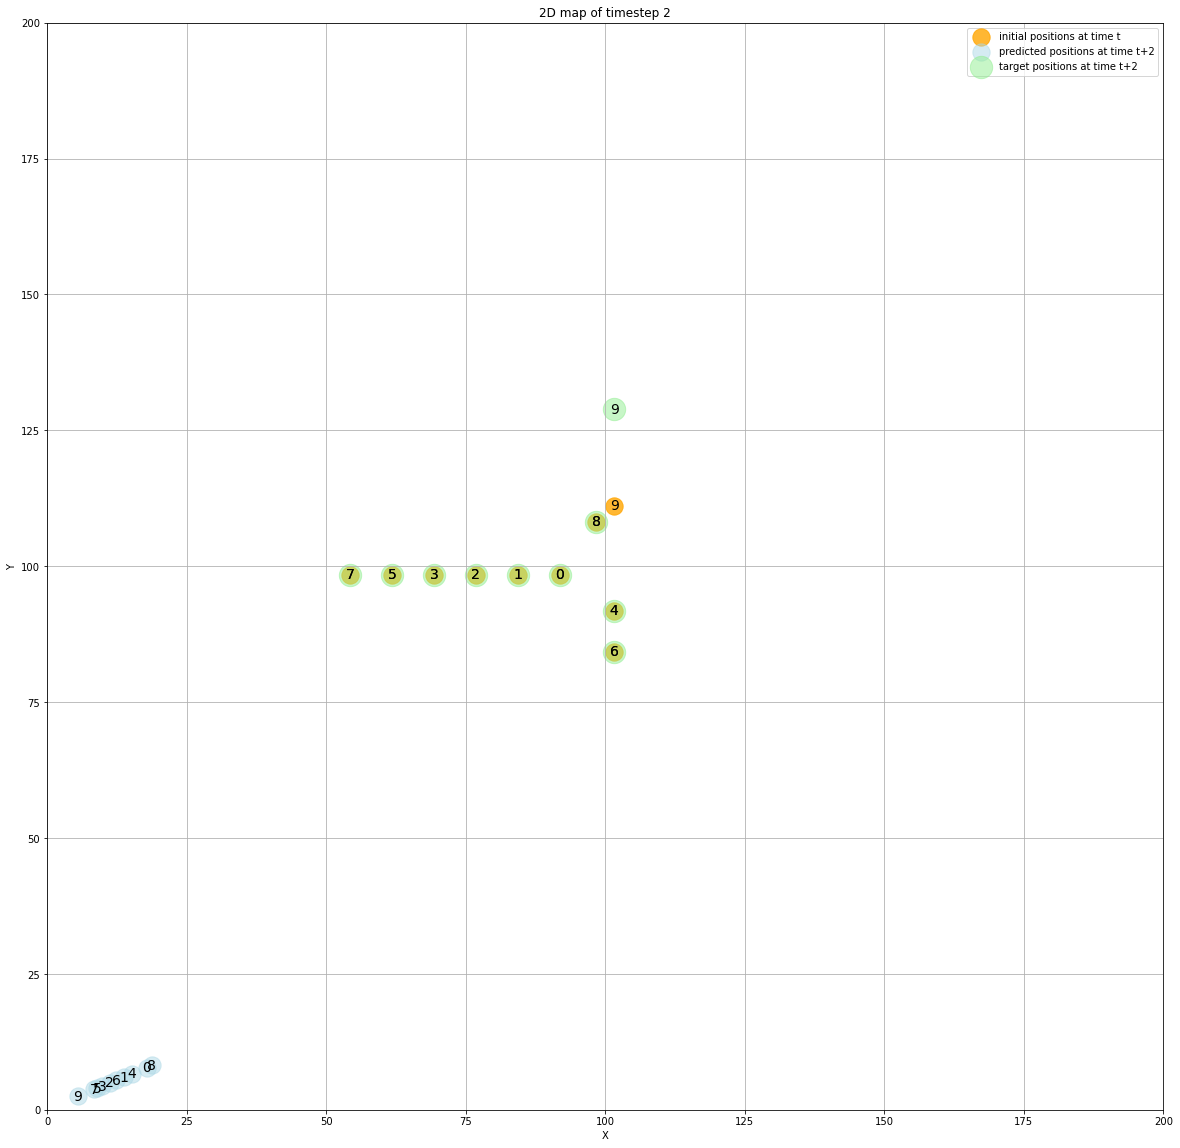

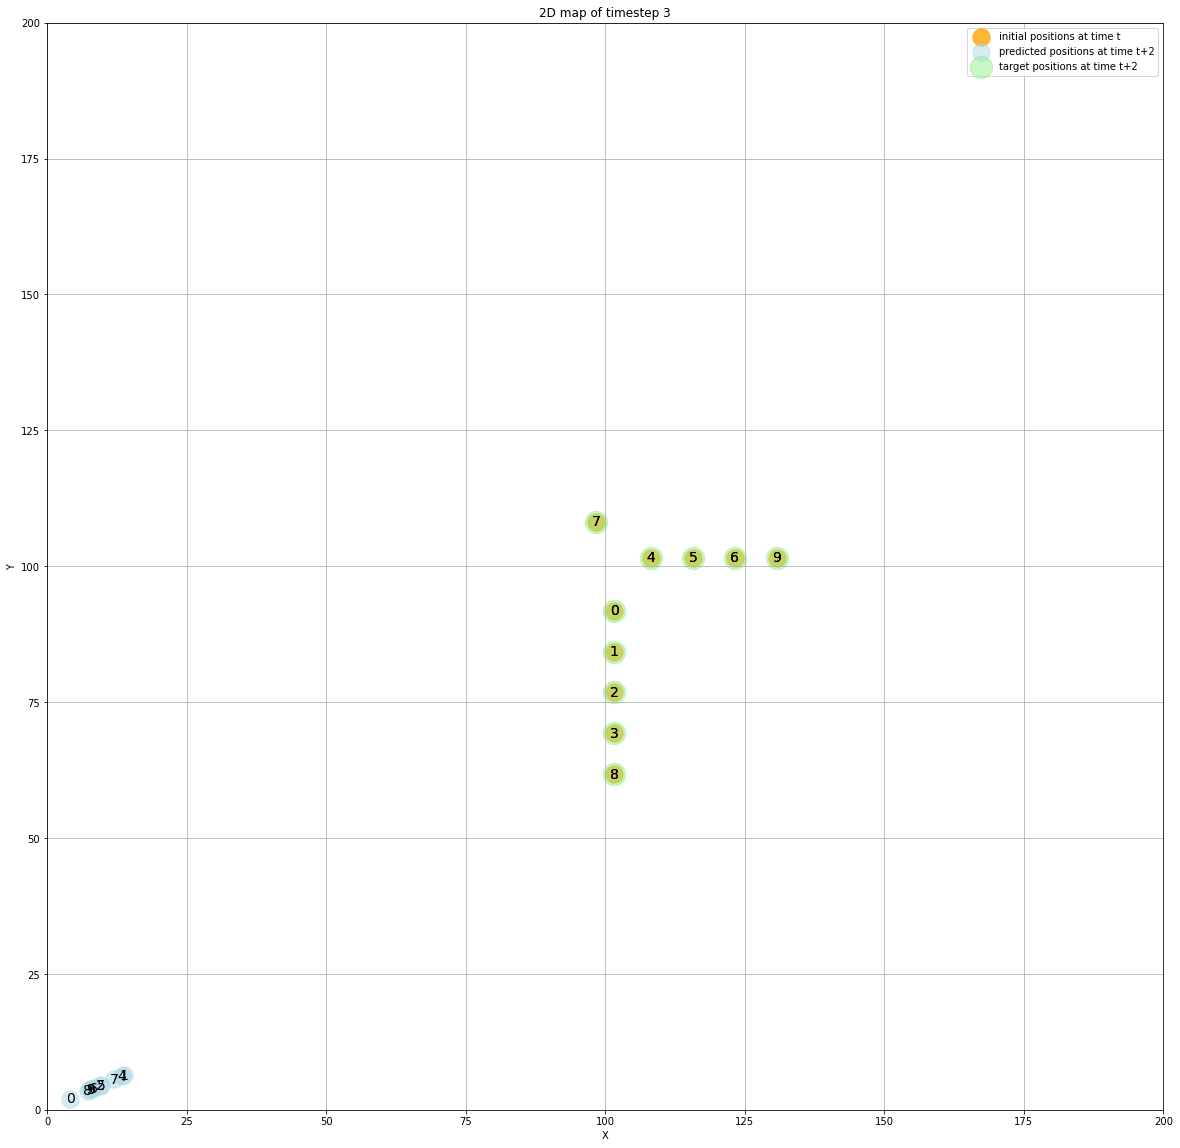

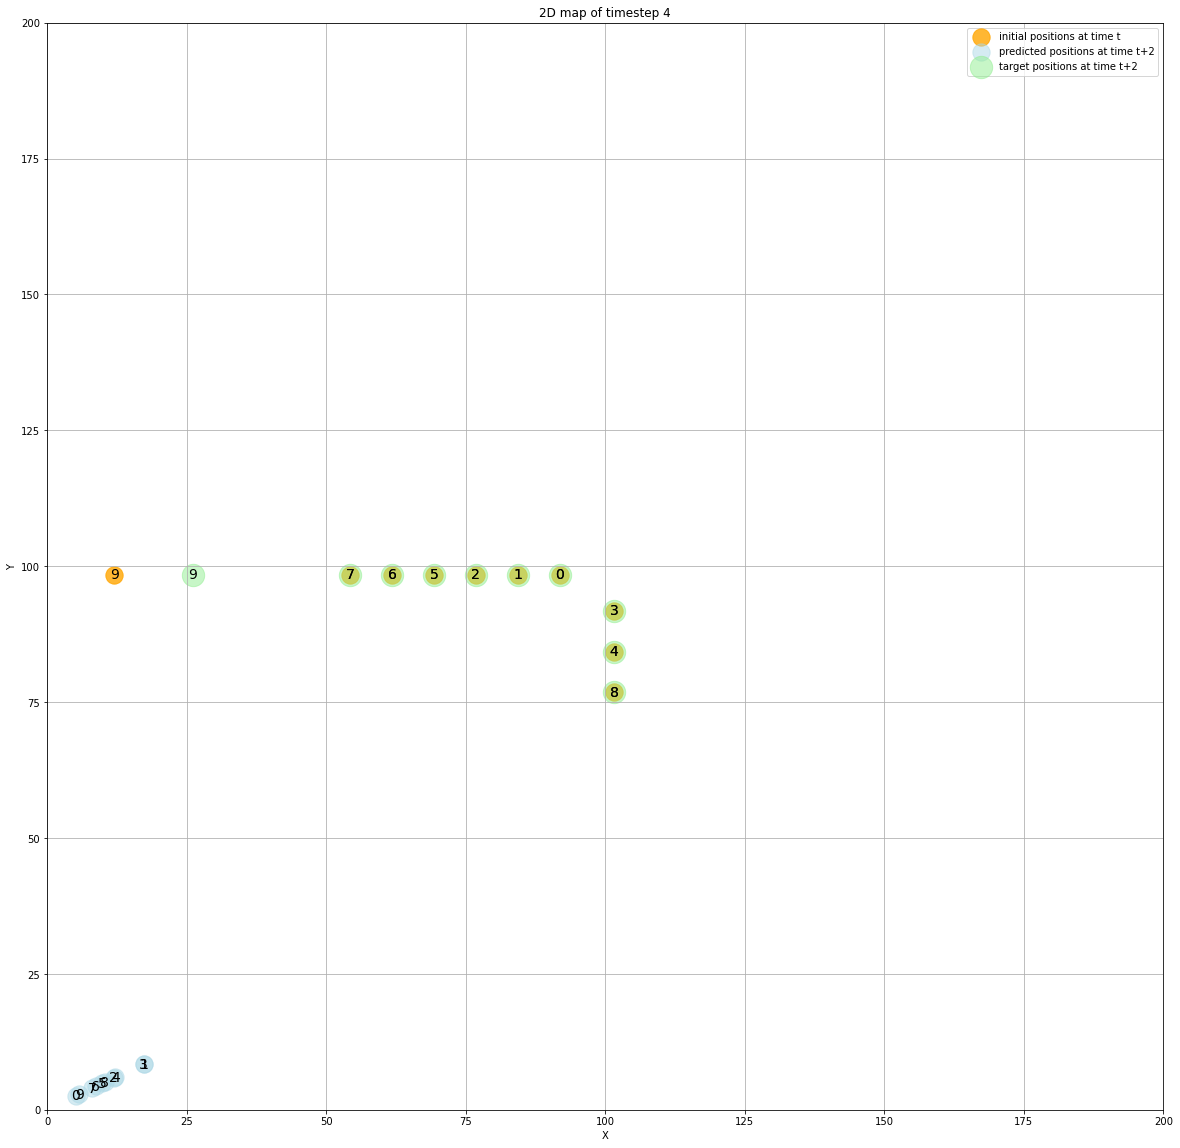

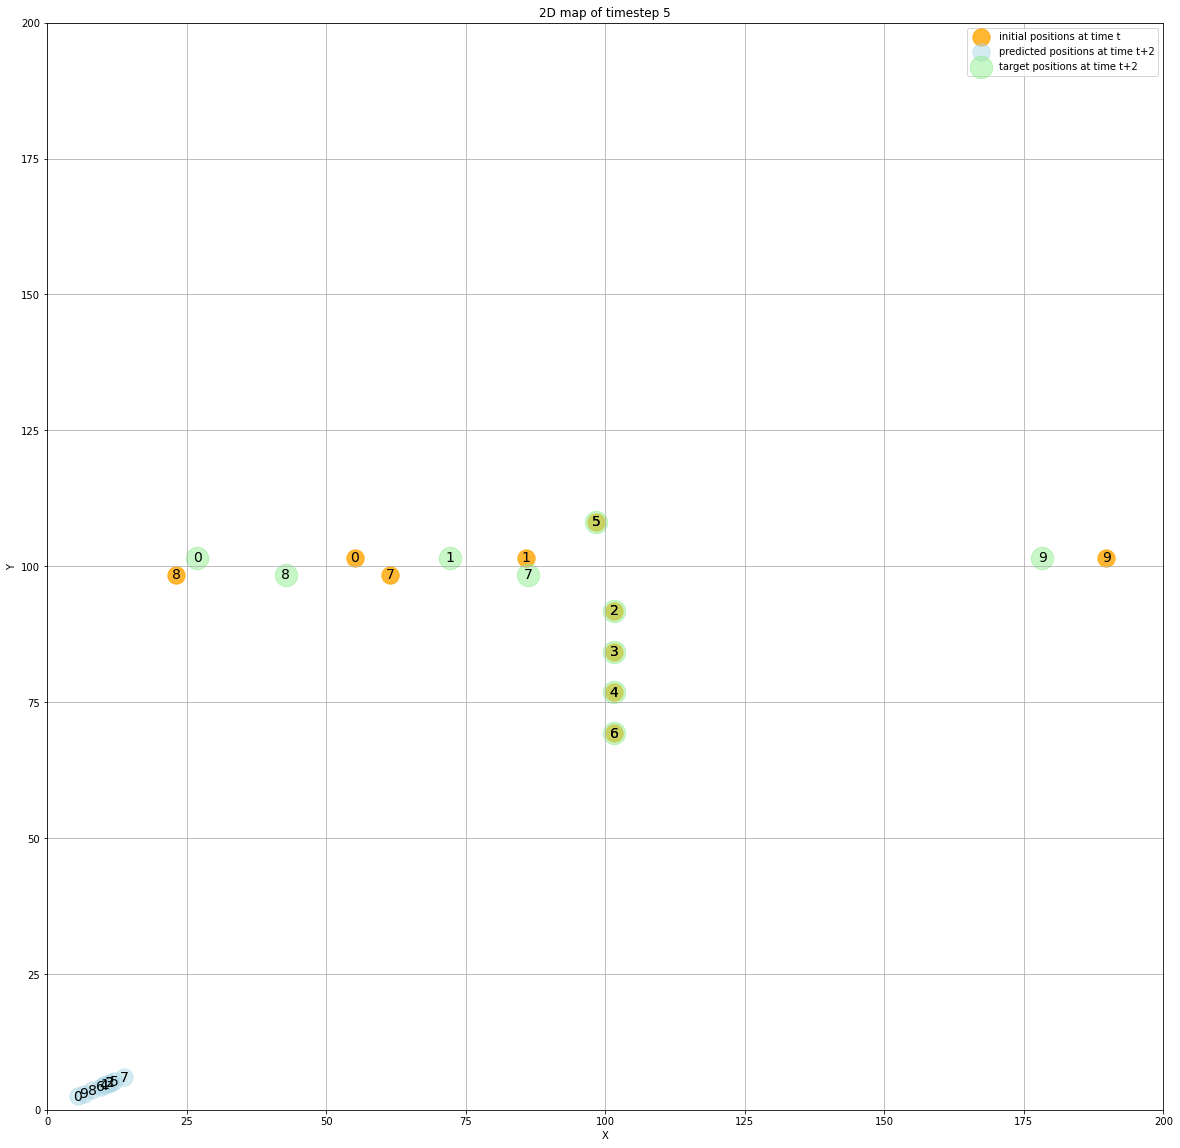

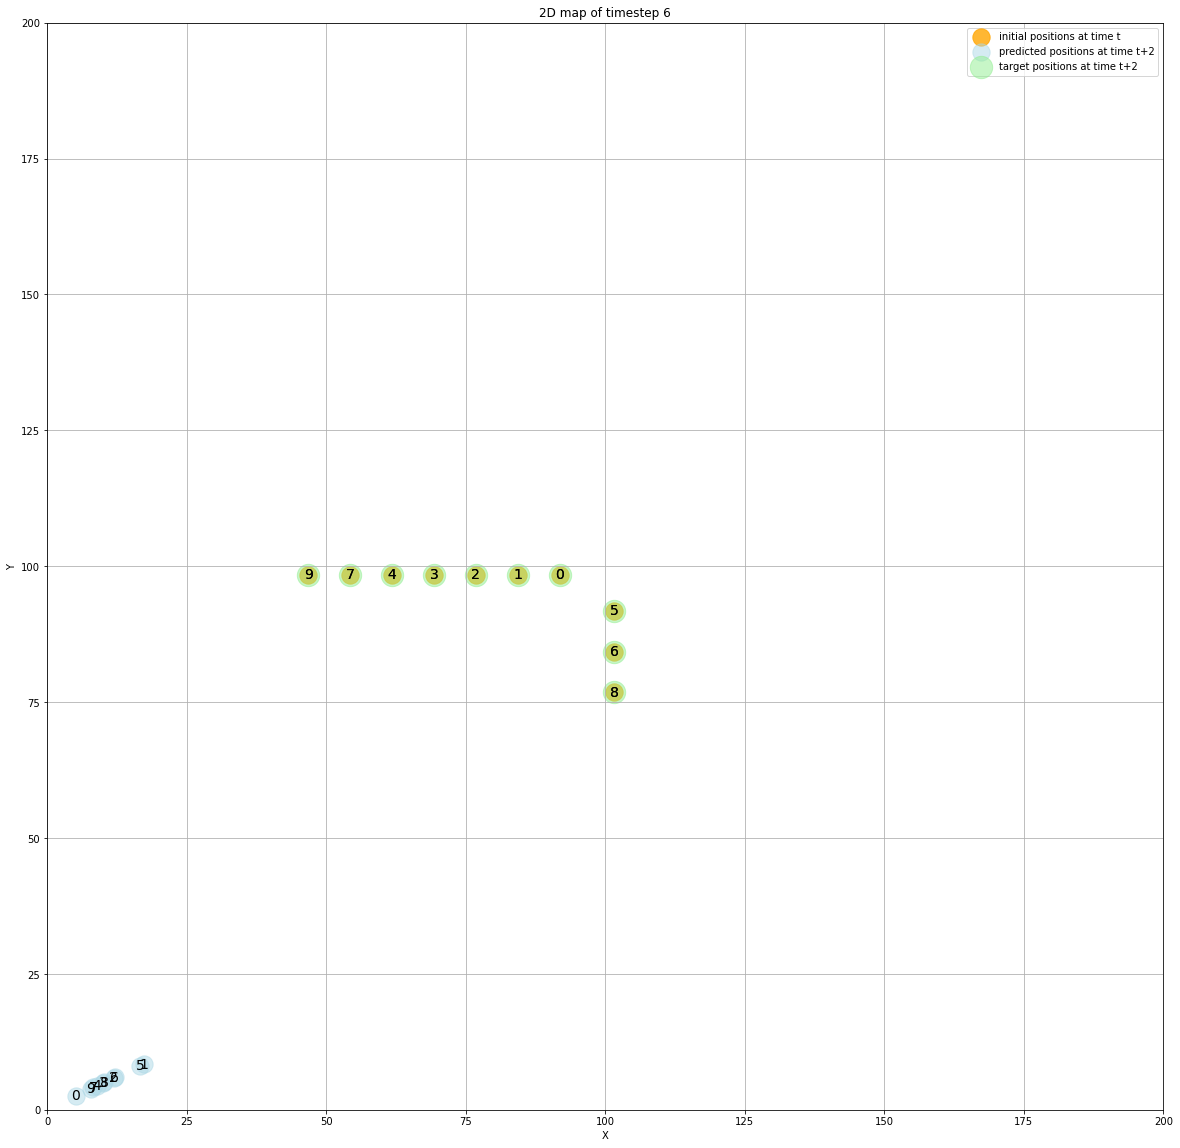

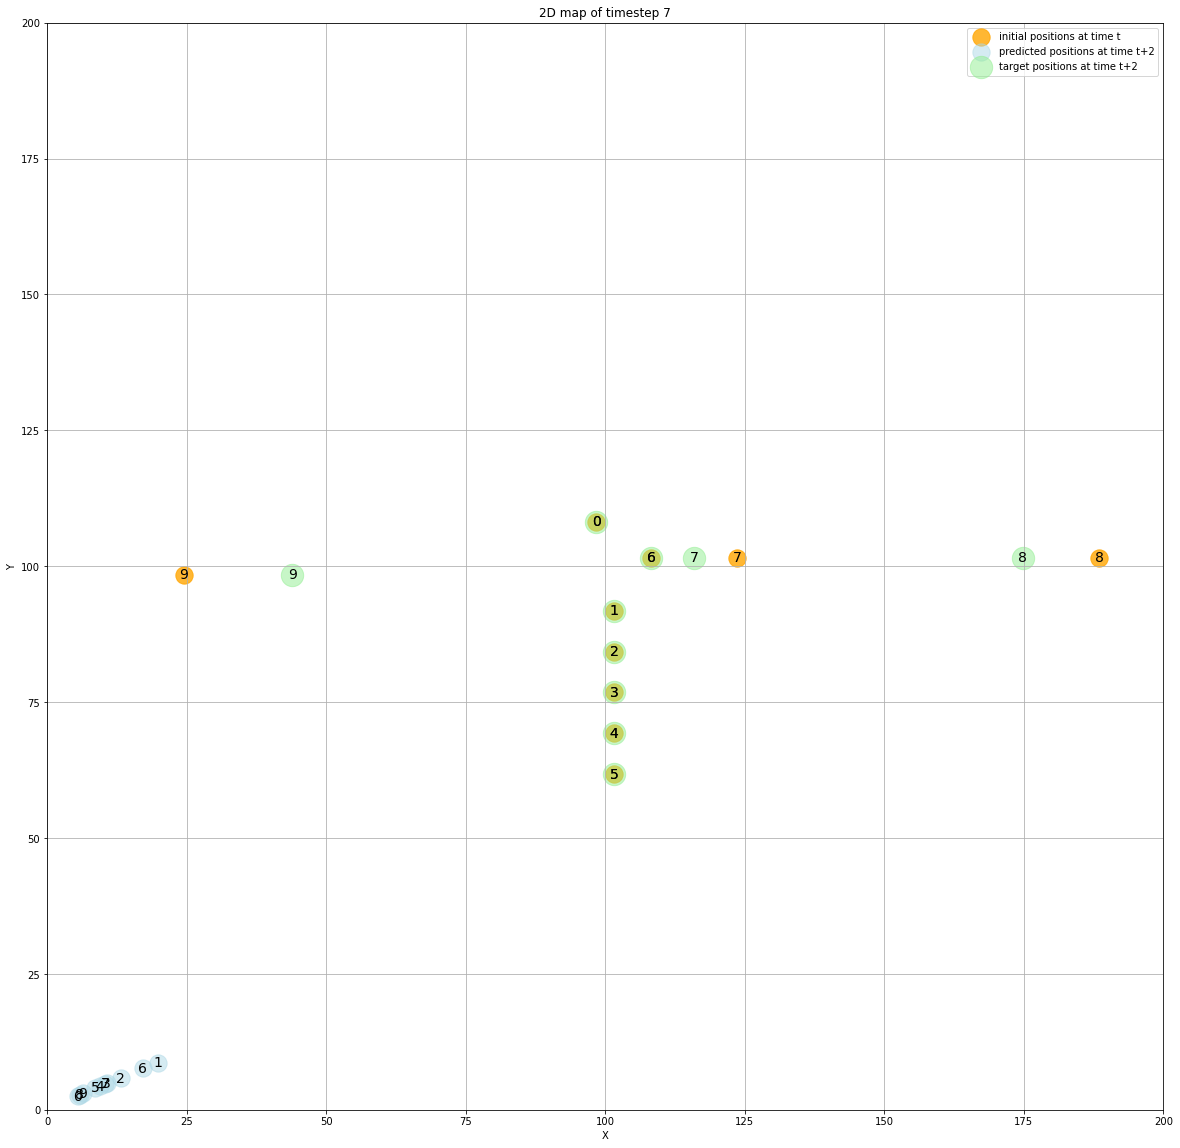

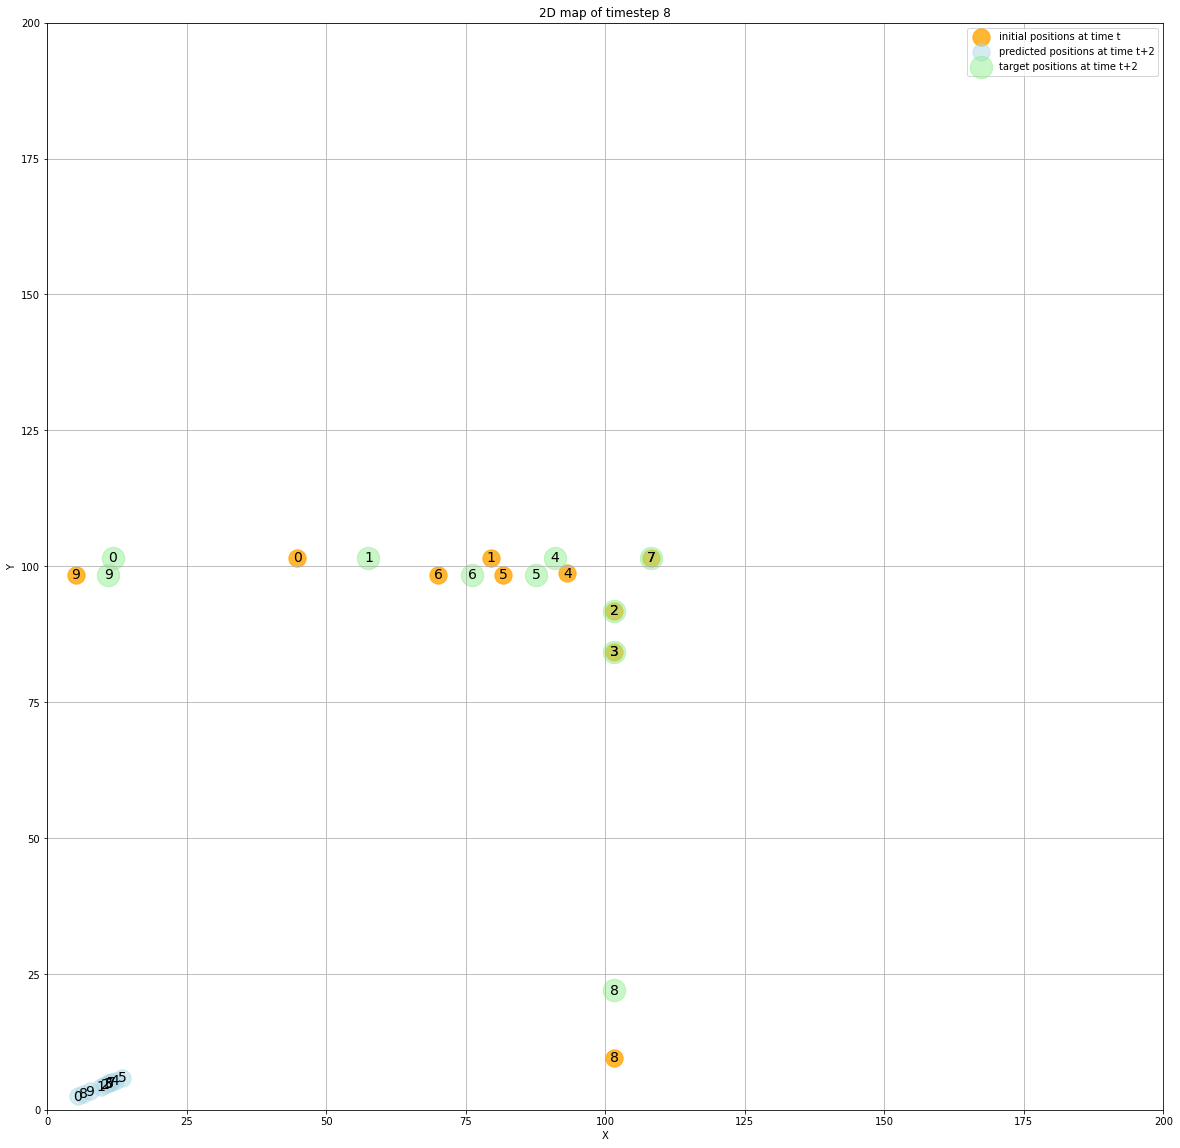

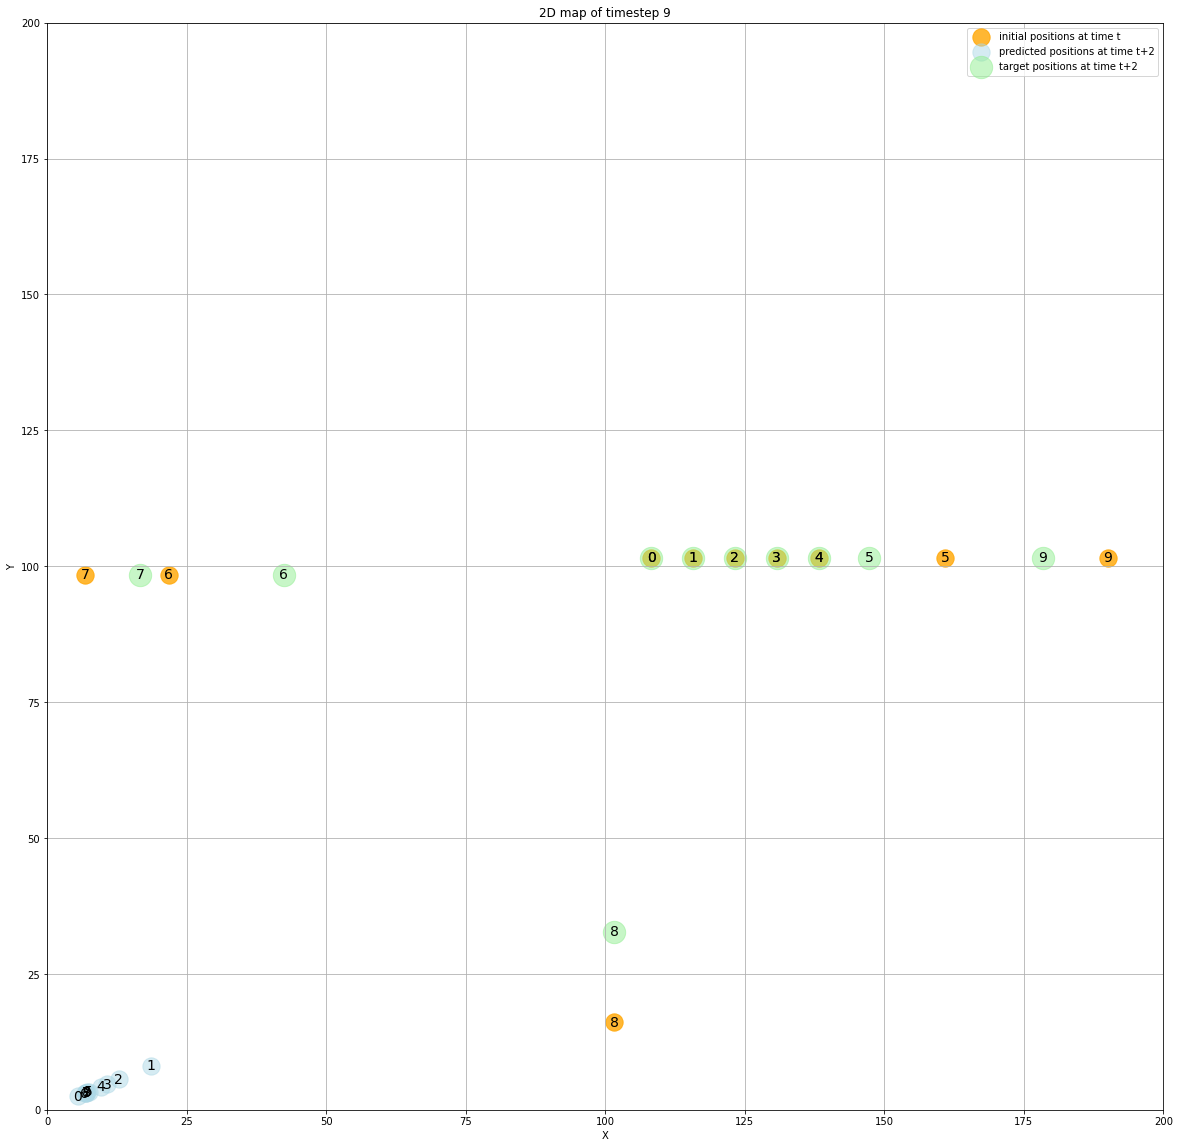

In [38]:
plot_results_model(
                   load_model, 
                   dataset_train,
                   start_from = 0,
                   end_at = 10,
                   edges_attr = True,
                   figsize = (20,20),
                   plot_intention = False
                  )

In [39]:
deleted_folders = delete_empty_r(directory= OUTPUT_DIR,
                                                 printstat = True)